# Forecasting of number of receipts scanned per month

In [1]:
%cd ..


/Users/bodhi/Documents/Projects/fetch-machine-learning-exercise


## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import torch

# autoreload
%load_ext autoreload
%autoreload 2
from src.utils.scaler import MinMaxScaler
from src.data.dataset import ReceiptCountDataset
from src.models import LSTM, RollingAverage, LinearRegression, Ensemble
from src.trainer import Trainer
from src.utils.metrics import RegressionMetrics
from src.utils.features import TimeFeatures


In [3]:
# Set random seed
np.random.seed(1)
torch.manual_seed(2)


## 1. Data Preprocessing

In [4]:
df_orig = pd.read_csv('data/raw/data_daily.csv')
df_orig.columns = ['date', 'count']
# Convert date column to datetime
df_orig['date'] = pd.to_datetime(df_orig['date'])


In [5]:
df = df_orig.copy()
# Display basic information about the data
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   count   365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB
None


In [6]:
# Summary statistics
print(df.describe())


                      date         count
count                  365  3.650000e+02
mean   2021-07-02 00:00:00  8.826566e+06
min    2021-01-01 00:00:00  7.095414e+06
25%    2021-04-02 00:00:00  8.142874e+06
50%    2021-07-02 00:00:00  8.799249e+06
75%    2021-10-01 00:00:00  9.476970e+06
max    2021-12-31 00:00:00  1.073886e+07
std                    NaN  7.820089e+05


## 2. Exploratory Data Analysis

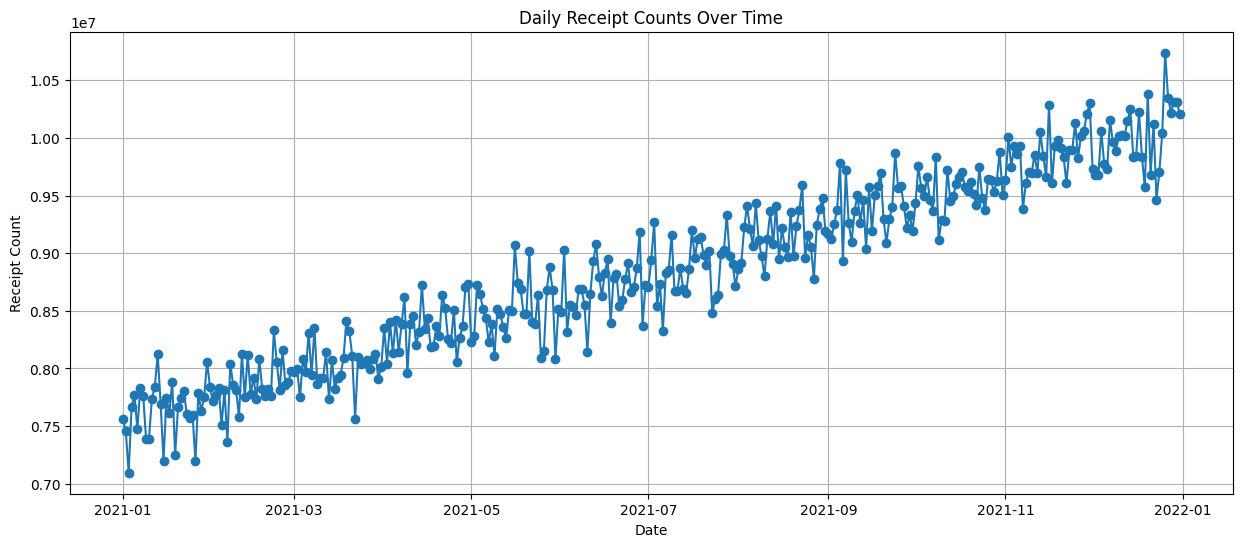

In [7]:
# Visualize the daily receipt counts over time
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['count'], marker='o', linestyle='-')
plt.title('Daily Receipt Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.show()


We see that there seems to be a trend in the data, so we will use a time series model to forecast the number of receipts scanned per month.

## 2. Data Preprocessing

In [8]:
df['month'] = df['date'].dt.month
# Split the data into train and validation sets
train_df = df[df['month'] < 11].copy()
val_df = df[df['month'].isin([10, 11, 12])].copy()
# Drop the month column
train_df.drop(columns=['month'], inplace=True)
val_df.drop(columns=['month'], inplace=True)


In [9]:
print(f"Before scaling: {train_df['count'].values[:5]}")
scaler = MinMaxScaler()
train_df['count'] = scaler.fit_transform(train_df['count'].values.reshape(-1, 1))
print(f"After scaling: {train_df['count'].values[:5]}")
rescaled = scaler.inverse_transform(train_df['count'].values.reshape(-1, 1))
print(f"After inverse scaling: {rescaled.reshape(-1)[:5]}")
# Scale the validation set
val_df['count'] = scaler.transform(val_df['count'].values.reshape(-1, 1))


Before scaling: [7564766 7455524 7095414 7666163 7771289]
After scaling: [0.16859223 0.12935227 0.         0.20501425 0.24277573]
After inverse scaling: [7564766. 7455524. 7095414. 7666163. 7771289.]


## 3. Feature Engineering

In [10]:
# Extract relevant features from the timestamp, such as day of the week, month, quarter, etc., as these can impact sales.
train_df = TimeFeatures.make_time_features(train_df)


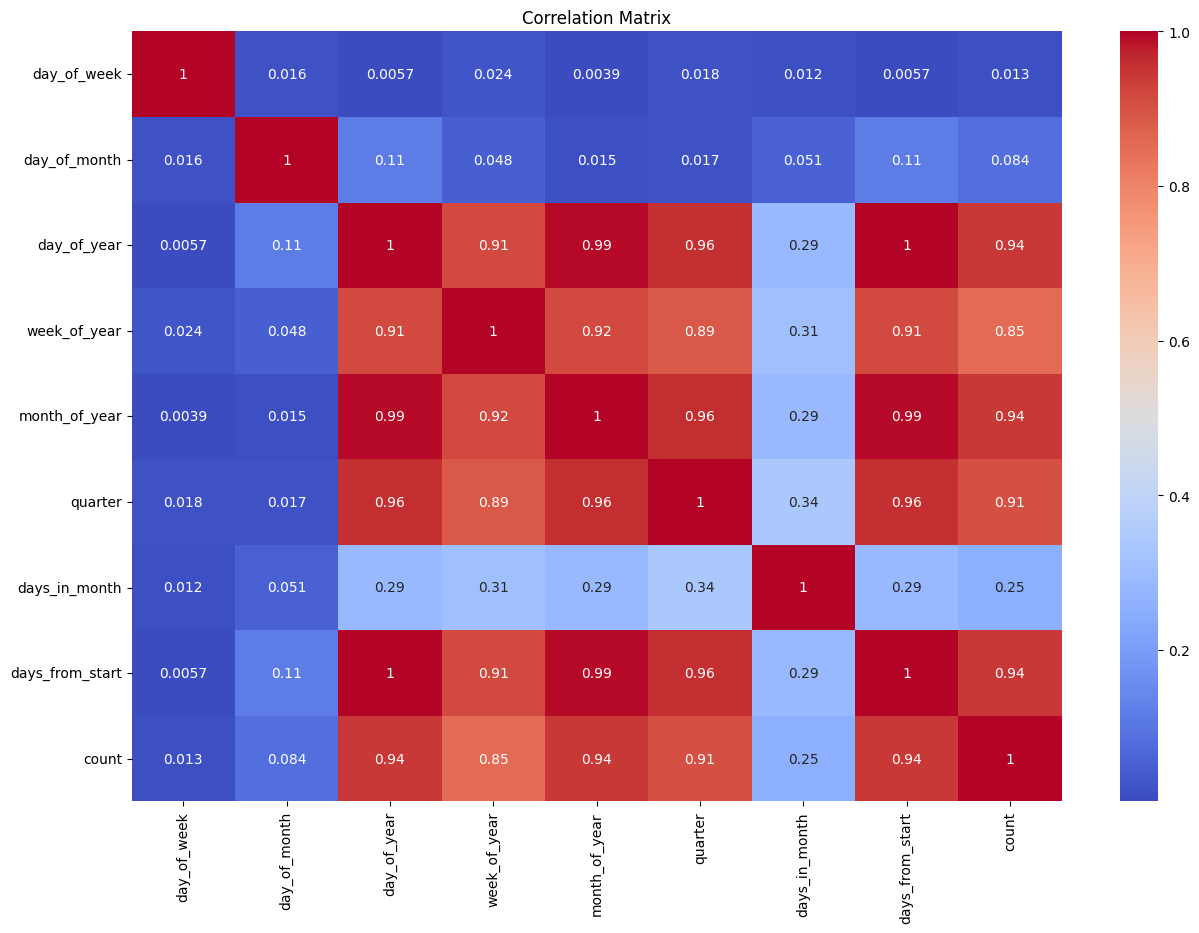

In [11]:
# Correlation matrix for the features and the target variable
corr = train_df.corr()
# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [12]:
# The features "day_of_week" and "day_of_month" are not correlated with the target variable "count", so we can drop them.


In [13]:
# Get the features for the validation set
val_df = TimeFeatures.make_time_features(val_df)
# Drop the day of week and day of month columns
train_df = train_df.drop(['day_of_week', 'day_of_month'], axis=1)
val_df = val_df.drop(['day_of_week', 'day_of_month'], axis=1)


In [14]:
print(f"Train data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")


Train data shape: (304, 7)
Validation data shape: (92, 7)


## 4. Model Selection

### 4.1. Baseline Model

In [15]:
# As seen in the EDA the data has a trend. So, first we will try to model the trend using a linear regression model.


Train predictions shape: (304, 1)
Validation predictions shape: (92, 1)
Train true shape: (304, 1)
Validation true shape: (92, 1)


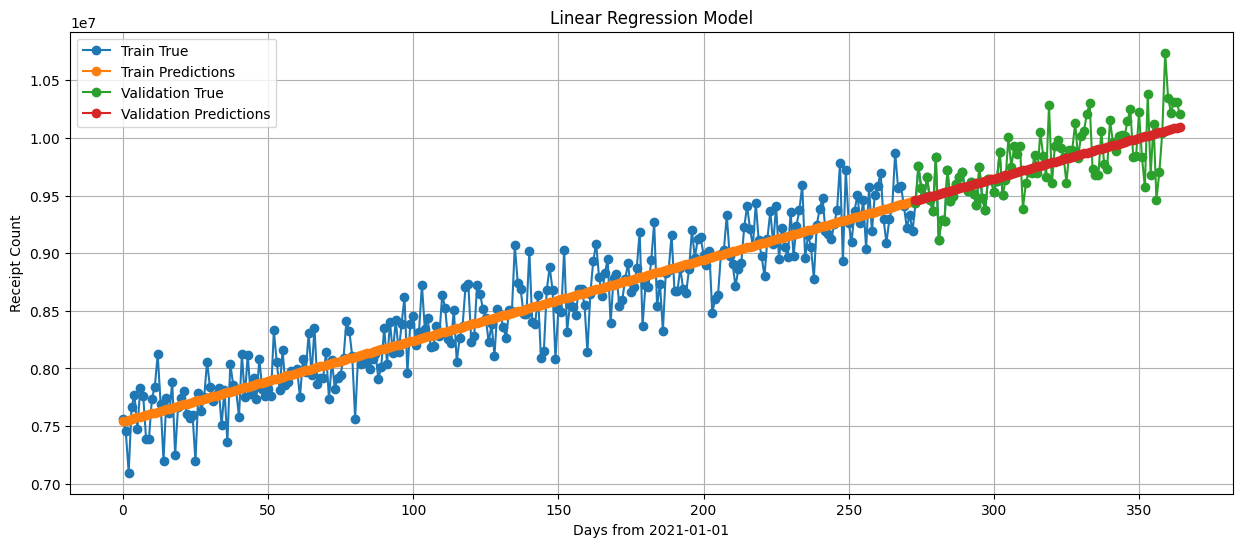

In [16]:
# Fit a linear regression model to the data
lr = LinearRegression()
lr.fit(train_df['days_from_start'].values, train_df['count'].values)
train_preds = lr.predict(train_df['days_from_start'].values)
val_preds = lr.predict(val_df['days_from_start'].values)
# Inverse transform of the true val for train and val sets
train_true_unscaled = scaler.inverse_transform(train_df['count'].values.reshape(-1, 1))
val_true_unscaled = scaler.inverse_transform(val_df['count'].values.reshape(-1, 1))
# Inverse transform the predictions
train_preds_unscaled = scaler.inverse_transform(train_preds.reshape(-1, 1))
val_preds_unscaled = scaler.inverse_transform(val_preds.reshape(-1, 1))
# print shapes
print(f"Train predictions shape: {train_preds_unscaled.shape}")
print(f"Validation predictions shape: {val_preds_unscaled.shape}")
print(f"Train true shape: {train_true_unscaled.shape}")
print(f"Validation true shape: {val_true_unscaled.shape}")
# Plot the predictions
plt.figure(figsize=(15, 6))
plt.plot(train_df["days_from_start"], train_true_unscaled, marker='o', linestyle='-', label='Train True')
plt.plot(train_df["days_from_start"], train_preds_unscaled, marker='o', linestyle='-', label='Train Predictions')
plt.plot(val_df["days_from_start"], val_true_unscaled, marker='o', linestyle='-', label='Validation True')
plt.plot(val_df["days_from_start"], val_preds_unscaled, marker='o', linestyle='-', label='Validation Predictions')
plt.title('Linear Regression Model')
plt.xlabel('Days from 2021-01-01')
plt.ylabel('Receipt Count')
plt.legend()
plt.grid(True)
plt.show()


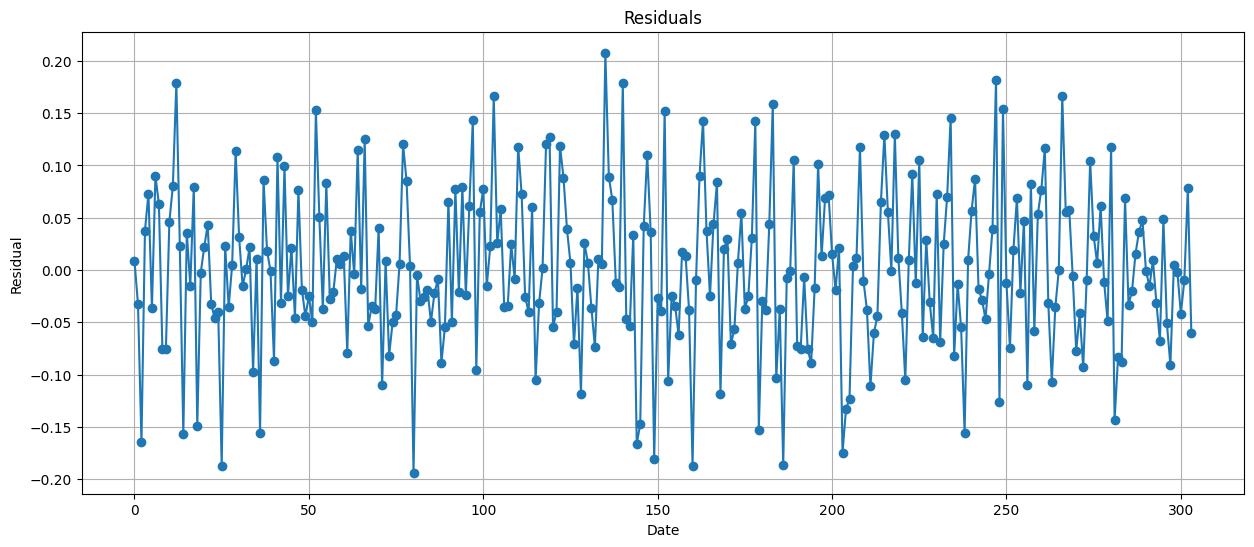

In [17]:
# error on the train set
residuals = train_df['count'].values - train_preds
# Plot the residuals
plt.figure(figsize=(15, 6))
plt.plot(train_df['days_from_start'], residuals, marker='o', linestyle='-')
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()


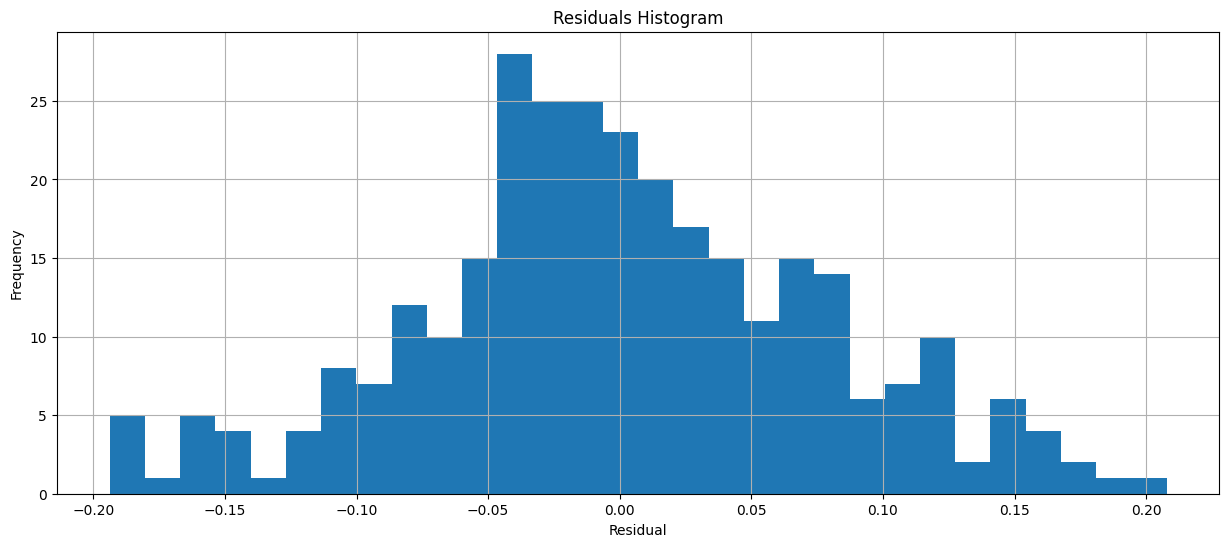

In [18]:
# Test the residual for gaussianity
# Plot the histogram
plt.figure(figsize=(15, 6))
plt.hist(residuals, bins=30)
plt.title('Residuals Histogram')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [19]:
# From above the residual seems to be normally distributed. However, it is not centered around zero, and there seems to be some irregularities in the histogram. So, we will try to model the residuals using a LSTM model.


In [20]:
# Update count column with the residuals
train_df['count'] = train_df['count'].values - train_preds
val_df['count'] = val_df['count'].values - val_preds


### 4.2. Variance Capture Model

In [21]:
# Create pytorch dataloaders
window_size = 30
prediction_size = 30

train_dataset = ReceiptCountDataset(train_df, window_size, prediction_size)
val_dataset = ReceiptCountDataset(val_df, window_size, prediction_size)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")


Train dataset length: 245
Validation dataset length: 33


In [22]:
seq_len, input_size = train_dataset[0][0].shape
output_size = train_dataset[0][1].shape[0]
print('Input size:', input_size)
print('Sequence length:', seq_len)
print('Output size:', output_size)
hidden_size = 64
num_layers = 2
# Store the variables to config
config = {
    'input_size': input_size,
    'output_size': output_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'seq_len': seq_len,
    'window_size': window_size,
    'prediction_size': prediction_size,
} 


Input size: 7
Sequence length: 30
Output size: 30


In [23]:
# Set random seed

model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss(reduction='mean')
# Create the trainer object
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    # learning_rate=0.0001,
    batch_size=32,
    num_epochs=1000,
    patience=10,
    device='cpu'
)


2023-11-21 01:06:59.372 | INFO     | src.trainer:__init__:29 - Using device: cpu


In [25]:
model, train_losses, val_losses = trainer.fit(train_dataset=train_dataset, val_dataset=val_dataset)


2023-11-21 01:06:59.516 | INFO     | src.trainer:fit:207 - Epoch: [1/1000], Train Loss: 0.01744855591095984, Val Loss: 0.01796616706997156
2023-11-21 01:06:59.517 | SUCCESS  | src.utils.callbacks:__call__:49 - Validation loss decreased (0.017966 --> 0.017966).
2023-11-21 01:06:59.632 | INFO     | src.trainer:fit:207 - Epoch: [2/1000], Train Loss: 0.0171810332685709, Val Loss: 0.01772274076938629
2023-11-21 01:06:59.633 | SUCCESS  | src.utils.callbacks:__call__:49 - Validation loss decreased (0.017723 --> 0.017723).
2023-11-21 01:06:59.799 | INFO     | src.trainer:fit:207 - Epoch: [3/1000], Train Loss: 0.01692980225197971, Val Loss: 0.017481427639722824
2023-11-21 01:06:59.799 | SUCCESS  | src.utils.callbacks:__call__:49 - Validation loss decreased (0.017481 --> 0.017481).
2023-11-21 01:06:59.916 | INFO     | src.trainer:fit:207 - Epoch: [4/1000], Train Loss: 0.016661940375342965, Val Loss: 0.017251083627343178
2023-11-21 01:06:59.916 | SUCCESS  | src.utils.callbacks:__call__:49 - Valid

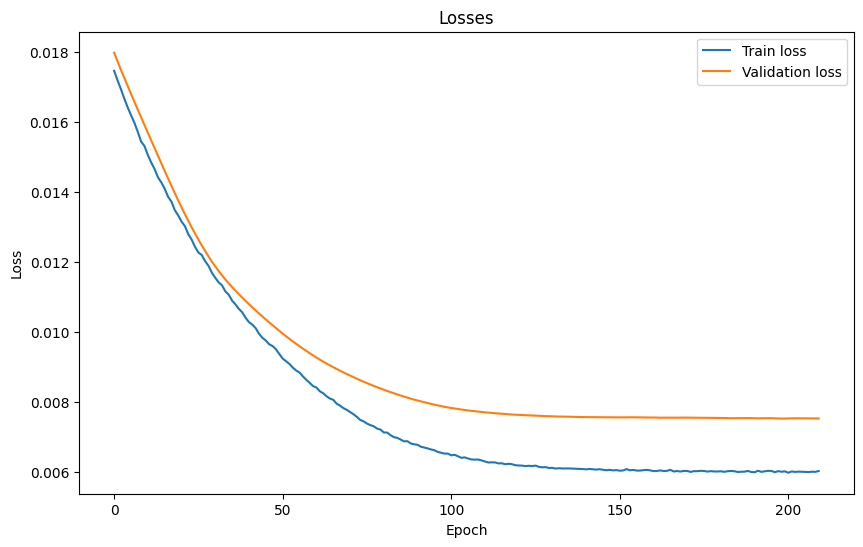

In [26]:
# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# 5. Model Evaluation

In [27]:
# Plot validation predictions
def plot_predictions(lr_model, nn_model, scaler, X, y, title, inverse_transform=True):
    # y is the residual
    # Reconstruction of the original time series (target variable)
    y_true_trend = lr_model.predict(X[:, -2]+30)
    y_true = y + y_true_trend
    # Get the predictions from the linear regression model
    lr_preds = lr_model.predict(X[:, -2]+30)
    if inverse_transform:
        lr_preds_unscaled = scaler.inverse_transform(lr_preds.reshape(-1, 1)).squeeze()
    else:
        lr_preds_unscaled = lr_preds
    # Get the predictions from the neural network model
    nn_model.eval()
    with torch.no_grad():
        nn_preds = nn_model(X.unsqueeze(0))[0] # This is the residual
        nn_preds = nn_preds.detach().cpu().numpy()
    # Aggregate the predictions by summing them
    print(type(lr_preds), type(nn_preds))
    y_pred = lr_preds + nn_preds

    # Plots
    plt.figure(figsize=(10, 6))
    # Plot previous 30 days
    history_y_true_res = X[:, -1].numpy()
    history_y_true = history_y_true_res + lr_model.predict(X[:, -2])
    history_days = np.arange(-len(history_y_true), 0)
    if inverse_transform:
        history_y_true = scaler.inverse_transform(history_y_true.reshape(-1, 1)).squeeze()
    plt.plot(history_days, history_y_true, label='Previous 30 days')


    # Plot the predictions
    if inverse_transform:
        y_true_unscaled = scaler.inverse_transform(y_true.reshape(-1, 1)).squeeze() 
        y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).squeeze()
    else:
        y_true_unscaled = y_true
        y_pred_unscaled = y_pred
    plt.plot(y_true_unscaled, label='True')
    plt.plot(lr_preds_unscaled, label='Predicted (LR)')
    plt.plot(y_pred_unscaled, label='Predicted (LR + LSTM)')

    # Plot rolling average
    rolling_avg = RollingAverage(window_size=30, prediction_size=30)
    rolling_avg_preds = rolling_avg.predict(history_y_true)
    plt.plot(rolling_avg_preds, label='Rolling Average')
    
    plt.title(title)
    plt.xlabel('Day')
    plt.ylabel('Receipt Count')
    plt.legend()
    plt.show()
    
    

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


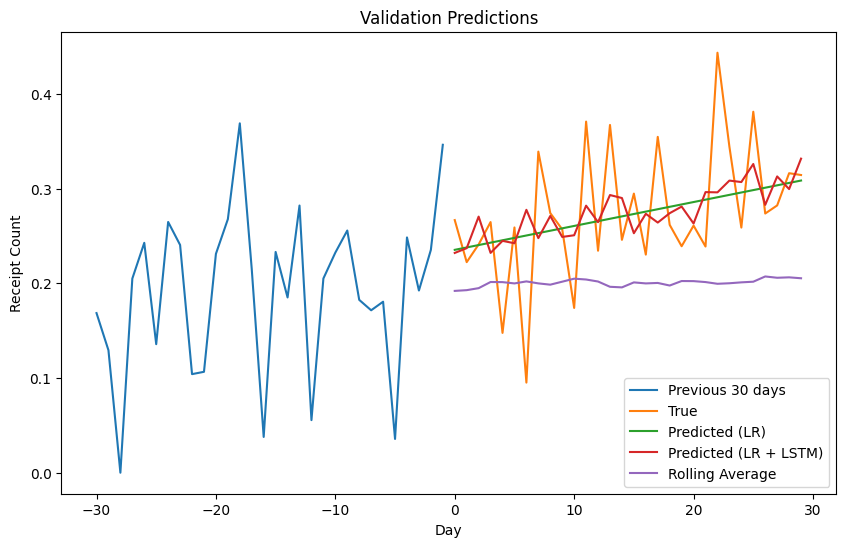

In [28]:
plot_predictions(lr, model, scaler, train_dataset[0][0], train_dataset[0][1], 'Validation Predictions', inverse_transform=False)


In [29]:
def compute_metrics(model, lr, dataset, inverse_transform=True):
    y_true, y_pred = [], []
    for idx in range(len(dataset)):
        X, y = val_dataset[idx]
        # Convert y to numpy array
        y = y.numpy()
        # Convert y_true (residual) to actual values
        y_true_trend = lr.predict(X[:, -2]+30)
        y = y + y_true_trend
        if inverse_transform:
            y = scaler.inverse_transform(y.reshape(-1, 1)).squeeze()

        if isinstance(model, LinearRegression):
            # print("Using Linear Regression model")
            pred = lr.predict(X[:, -2]+window_size)
        else:
            pred = model.predict(X)
        # Unscale the predictions
        if inverse_transform:
            pred = scaler.inverse_transform(pred.reshape(-1, 1)).squeeze()
            y = scaler.inverse_transform(y.reshape(-1, 1)).squeeze()
        
        # Append to the list
        y_true.append(y)
        y_pred.append(pred)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    metrics = RegressionMetrics(y_true, y_pred)
    return metrics.all()


In [30]:
ens_model = Ensemble(lr, model, window_size)


In [31]:
ens_metrics = compute_metrics(ens_model, lr, val_dataset, inverse_transform=False)
lr_metrics =  compute_metrics(lr, lr, val_dataset, inverse_transform=False)

# Create dataframe for the metrics
metrics_df = pd.DataFrame([lr_metrics, ens_metrics], index=['LR', 'Ensemble'])


In [32]:
metrics_df


,mae,mse,rmse
LR,0.0649,0.0062,0.0782
Ensemble,0.0646,0.0062,0.0782


# 6. Model Interpretation

It seems like the ensemble model is slightly better than just linear regression model. We will use this model to forecast the number of receipts scanned per month.

## 7. Model Deployment

In [35]:
# Before deploying the model, we will train it on the entire dataset.
train_df = TimeFeatures.make_time_features(df[["date", "count"]].copy())
train_df.drop(columns=['day_of_week', 'day_of_month'], inplace=True)
# Scale the data
scaler = MinMaxScaler()
train_df['count'] = scaler.fit_transform(train_df['count'].values.reshape(-1, 1))
# Fit the linear regression model
lr = LinearRegression()
lr.fit(train_df['days_from_start'].values, train_df['count'].values)
# Update the count column with the residuals
train_df['count'] = train_df['count'].values - lr.predict(train_df['days_from_start'].values)
# Create the dataset
train_dataset = ReceiptCountDataset(train_df, window_size, prediction_size)
# Train the LSTM model
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.MSELoss(reduction='mean')
# Create the trainer object
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    # learning_rate=0.0001,
    batch_size=32,
    num_epochs=200,
    patience=10,
    device='cpu'
)
model, train_losses, val_losses = trainer.fit(train_dataset=train_dataset, val_dataset=None)


2023-11-21 01:08:41.706 | INFO     | src.trainer:__init__:29 - Using device: cpu
2023-11-21 01:08:41.844 | INFO     | src.trainer:fit:207 - Epoch: [1/200], Train Loss: 0.015840116608887914
2023-11-21 01:08:41.845 | SUCCESS  | src.utils.callbacks:__call__:49 - Validation loss decreased (nan --> nan).
2023-11-21 01:08:41.980 | INFO     | src.trainer:fit:207 - Epoch: [2/200], Train Loss: 0.015427978895604611
2023-11-21 01:08:41.981 | SUCCESS  | src.utils.callbacks:__call__:49 - Validation loss decreased (nan --> nan).
2023-11-21 01:08:42.115 | INFO     | src.trainer:fit:207 - Epoch: [3/200], Train Loss: 0.014924028422683477
2023-11-21 01:08:42.116 | SUCCESS  | src.utils.callbacks:__call__:49 - Validation loss decreased (nan --> nan).
2023-11-21 01:08:42.252 | INFO     | src.trainer:fit:207 - Epoch: [4/200], Train Loss: 0.014412146247923372
2023-11-21 01:08:42.253 | SUCCESS  | src.utils.callbacks:__call__:49 - Validation loss decreased (nan --> nan).
2023-11-21 01:08:42.387 | INFO     | sr

In [36]:
# Save the models, scaler for deployment
# Save the scaler
joblib.dump(scaler, 'models/scaler.pkl')
# Save the linear regression model
joblib.dump(lr, 'models/lr.pkl')
# Save the LSTM model
torch.save(model.state_dict(), 'models/lstm.pth')
# Save the config
joblib.dump(config, 'models/config.pkl')


['models/config.pkl']

### Now we will create a streamlit app to deploy our model.